In [0]:
# Import Libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Transformations
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
#Dataset and Creating Train/Test Split
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
#Dataloader Arguments & Test/Train Dataloaders

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


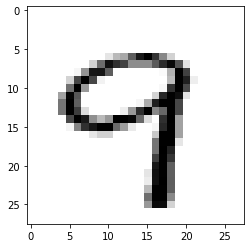

In [5]:
#Data Statistics

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [0]:
#Model Building 

# Build the neural network, expand on top of nn.Module
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolution block-1
        self.conv_blk1 = nn.Sequential(
            # input layer
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0,  bias=False),   
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU()
        )

        # Transition Layer for Convolution block-1
        self.conv_blk1_transition = nn.Sequential(
            nn.MaxPool2d(2, 2),                                                                       
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0,  bias=False),   
        )

        # Convolution block-2
        self.conv_blk2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0,  bias=False),  
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=0,  bias=False), 
            nn.ReLU()
        )

        # Output Block
        self.output_block = nn.Sequential(
            nn.AvgPool2d(kernel_size=5),                                                              
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(1, 1), padding=0,  bias=False),  
            # no ReLU for last covv layer
        ) # output_size = 1

    def forward(self, x):

        x = self.conv_blk1(x) 
        x = self.conv_blk1_transition(x)
        x = self.conv_blk2(x) 
        x = self.output_block(x) 
        x = x.view(-1, 10)
        return F.log_softmax(x)


In [7]:
# Model Parameters

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          18,432
              ReLU-6           [-1, 64, 22, 22]               0
         MaxPool2d-7           [-1, 64, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           1,024
            Conv2d-9             [-1, 32, 9, 9]           4,608
             ReLU-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 64, 7, 7]          18,432
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 5, 5]          73,728
             ReLU-14            [-

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
#Training and Testing

from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [9]:
# Let's Train and test our model
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.33750876784324646 Batch_id=468 Accuracy=34.91: 100%|██████████| 469/469 [00:10<00:00, 45.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2945, Accuracy: 9072/10000 (90.72%)

EPOCH: 1


Loss=0.1705154925584793 Batch_id=468 Accuracy=94.82: 100%|██████████| 469/469 [00:10<00:00, 45.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0968, Accuracy: 9704/10000 (97.04%)

EPOCH: 2


Loss=0.04500862956047058 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:10<00:00, 43.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9796/10000 (97.96%)

EPOCH: 3


Loss=0.027208825573325157 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:10<00:00, 44.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9797/10000 (97.97%)

EPOCH: 4


Loss=0.03431355953216553 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9793/10000 (97.93%)

EPOCH: 5


Loss=0.03132660314440727 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:10<00:00, 45.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9871/10000 (98.71%)

EPOCH: 6


Loss=0.08867073059082031 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:10<00:00, 45.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9857/10000 (98.57%)

EPOCH: 7


Loss=0.03301684558391571 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:10<00:00, 42.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9872/10000 (98.72%)

EPOCH: 8


Loss=0.07748693227767944 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:10<00:00, 42.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9881/10000 (98.81%)

EPOCH: 9


Loss=0.006656473036855459 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:10<00:00, 43.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.004066621419042349 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:10<00:00, 44.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9890/10000 (98.90%)

EPOCH: 11


Loss=0.008941163308918476 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.018370553851127625 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:10<00:00, 42.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9906/10000 (99.06%)

EPOCH: 13


Loss=0.02933490090072155 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:10<00:00, 43.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9873/10000 (98.73%)

EPOCH: 14


Loss=0.0033539135474711657 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:10<00:00, 42.64it/s]



Test set: Average loss: 0.0352, Accuracy: 9893/10000 (98.93%)



Text(0.5, 1.0, 'Test Accuracy')

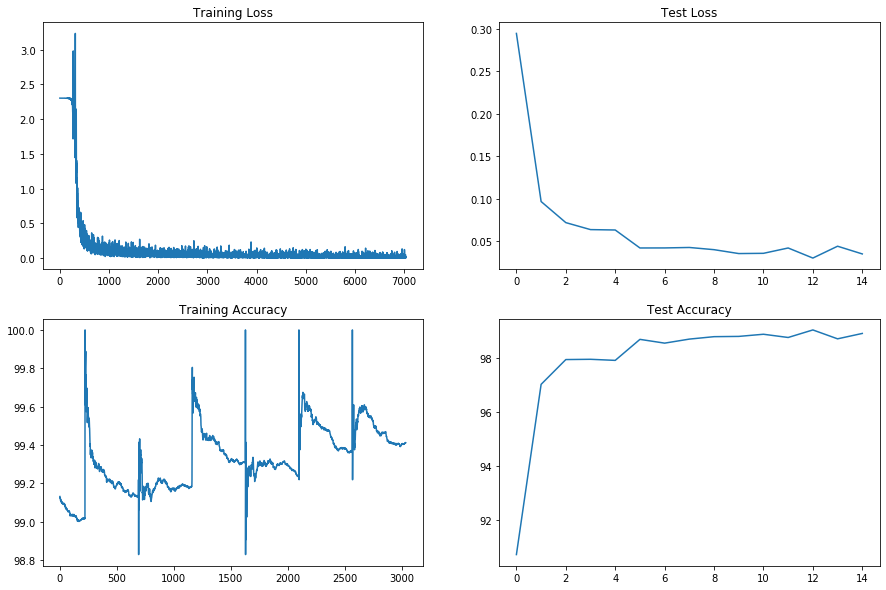

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")